## Test Data Tutorial 
In this tutorial, we show how this package can be used on masked data. The data can have several components (here, in x, y, and z direction) and in several time steps. 

In [1]:
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.ndimage import binary_erosion	
import numpy as np
from matplotlib import cm
import scipy.io

### load data 

In [2]:
import zipfile
import os
from pathlib import Path

data_dir = Path(os.getcwd()).parent / "data"   ## change if appropriate

with zipfile.ZipFile(data_dir / 'SampleDeformationData.zip', 'r') as zip_ref:
    zip_ref.extract('SampleData.mat')

In [3]:
from mift.classes import Param, Axis

subj_name = 'SampleData'
f=scipy.io.loadmat('SampleData.mat')
# Param class was designed espciafically for deformation data that we have, change it based on your application 
subj = Param(subj_name, '')
subj.GetData(f)

In [4]:
# define 1D axis 
XAxis = (np.arange(0,subj.nAP)*subj.dAP) #unit m
YAxis = (np.arange(0,subj.nRL)*subj.dRL) #unit m
ZAxis = (np.arange(0,subj.nFH)*subj.dFH) #unit m
# Axis class was designed to incorporate x, y, and z axis 
Axis_raw = Axis(XAxis,YAxis,ZAxis)

# create 3D axis from 1D ones 
x3d = np.tile(XAxis.reshape((subj.nAP,1))[:,:,np.newaxis],(1,subj.nRL,subj.nFH))
y3d = np.tile(YAxis.reshape((1,subj.nRL))[:,:,np.newaxis],(subj.nFH,1,subj.nAP))
z3d = np.tile(ZAxis.reshape((1,1,subj.nFH)),(subj.nAP,subj.nRL,1))


### Pre-procesing 

In [6]:
from mift.classes import Deformation, PutValueId

# just keep WM and GM , out: mask_erosion 
mask = np.zeros(subj.GM.shape,dtype='bool')
mask[:,:,:]=True
id=np.where((subj.GM<0.1) & (subj.WM<0.1))
mask[id[0],id[1],id[2]]=False
# erosion using determiend kernel
kernel = np.ones((3,3,3))
mask_erosion=binary_erosion(mask,structure=kernel).astype(bool)

# remove background noise 
u4d_mean = [];u4d_mask =[]; u4d_mask_ero = []; 
for i in range(subj.N):
    n0 = int(i)

    # mean bw 2 dif polarities
    u3d_mean = Deformation((subj.LPH_dispAPcorr[0,n0,:,:,:]-subj.LPH_dispAPcorr[1,n0,:,:,:])/2,\
                               (subj.LPH_dispRLcorr[0,n0,:,:,:]-subj.LPH_dispRLcorr[1,n0,:,:,:])/2,\
                               (subj.LPH_dispFHcorr[0,n0,:,:,:]-subj.LPH_dispFHcorr[1,n0,:,:,:])/2)
    u4d_mean.append(u3d_mean)
    
    # put nan for everything except GM and WM
    id=np.where(~mask)
    u3d_mask = deepcopy(u3d_mean)
    u3d_mask = PutValueId(id,u3d_mask,np.nan) 
    u4d_mask.append(u3d_mask)
    
    ## remove near csf and add zero there
    id=np.where(~mask_erosion)
    u3d_mask_ero = deepcopy(u3d_mean)
    u3d_mask_ero = PutValueId(id,u3d_mask_ero,0)
    u4d_mask_ero.append(u3d_mask_ero)

### Fourier decomposition 

In [7]:
from mift.functions_3D import (
    efficient_unstructured_FFT_3D_oneTime, 
    efficient_unstructured_FFT_3D_eachTime
)

# define N and padding, q (q=0.9 mean 10% extra padding)       
Nx = 4; Ny = 4; Nz = 4; q=0.9

# define matrices for saving Fourier-based coefficient for each vector (AP, RL, FH) and each time step (subj.N) 
coefx_4d = np.zeros(((2*Nx+1)*(2*Ny+1)*(2*Nz+1),subj.N))
coefy_4d = np.zeros(((2*Nx+1)*(2*Ny+1)*(2*Nz+1),subj.N))
coefz_4d = np.zeros(((2*Nx+1)*(2*Ny+1)*(2*Nz+1),subj.N))

# define x1d, y1d, and z1d
x1d=XAxis;y1d=YAxis;z1d=ZAxis;
# define, kx0, ky0, kx0
kx = 2*np.pi/(np.max(x3d)-np.min(x3d))
ky = 2*np.pi/(np.max(y3d)-np.min(y3d))
kz = 2*np.pi/(np.max(z3d)-np.min(z3d))

# compute [AA] and its SVD which needs to be done only once, no matter how many time steps do we have
(AA, invAA,u, s, vh) = efficient_unstructured_FFT_3D_oneTime(x1d,y1d,z1d,q*kx,q*ky,q*kz,Nx,Ny,Nz,mask_erosion)

# compute [BB] and [xx] for each time step and each direction using pre-computed [AA] and its inversion 
for i in range((subj.N)):
    n0 = int(i)

    u3d_mask_ero = u4d_mask_ero[n0]
    
    (bbx,coefx) = efficient_unstructured_FFT_3D_eachTime(u3d_mask_ero.ux,x1d,y1d,z1d,q*kx,q*ky,q*kz,Nx,Ny,Nz,AA,invAA, u, s, vh)
    (bby,coefy) = efficient_unstructured_FFT_3D_eachTime(u3d_mask_ero.uy,x1d,y1d,z1d,q*kx,q*ky,q*kz,Nx,Ny,Nz,AA,invAA, u, s, vh)
    (bbz,coefz) = efficient_unstructured_FFT_3D_eachTime(u3d_mask_ero.uz,x1d,y1d,z1d,q*kx,q*ky,q*kz,Nx,Ny,Nz,AA,invAA, u, s, vh)
    
    coefx_4d[:,n0]=coefx.flatten()
    coefy_4d[:,n0]=coefy.flatten()
    coefz_4d[:,n0]=coefz.flatten()


### Fourier reconstruction

In [8]:
from mift.functions_3D import (
    efficient_unstructured_IFFT_3D
)

# determine the time point we wanna reconstruct the data
n0 = 14

# reconstruct the data 
recon_Nx = efficient_unstructured_IFFT_3D(coefx_4d[:,n0],XAxis,YAxis,ZAxis,q*kx,q*ky,q*kz,Nx,Ny,Nz)  
recon_Ny = efficient_unstructured_IFFT_3D(coefy_4d[:,n0],XAxis,YAxis,ZAxis,q*kx,q*ky,q*kz,Nx,Ny,Nz)
recon_Nz = efficient_unstructured_IFFT_3D(coefz_4d[:,n0],XAxis,YAxis,ZAxis,q*kx,q*ky,q*kz,Nx,Ny,Nz)
# put nan outside of mask for reconstructed data
id1=np.where(~mask)
recon_Nx[id1]=np.nan;recon_Ny[id1]=np.nan;recon_Nz[id1]=np.nan


### Visualization

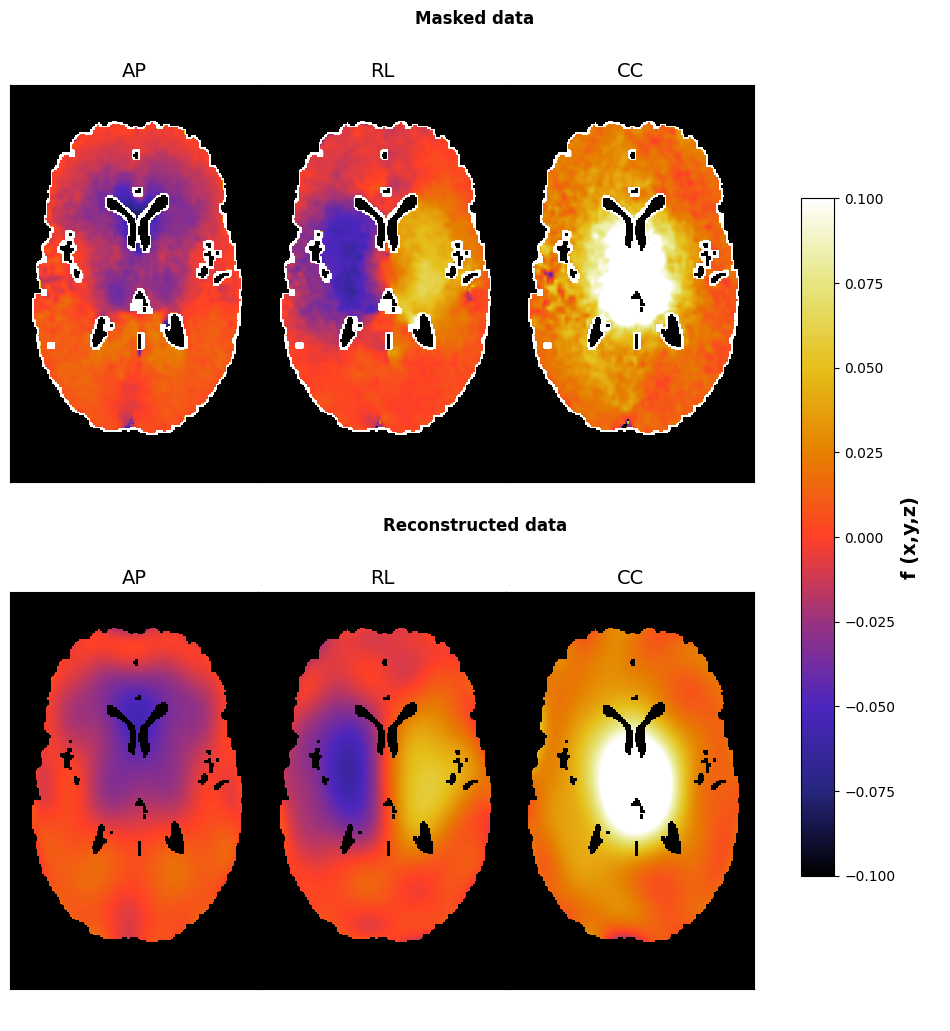

In [9]:
from matplotlib.gridspec import SubplotSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# put nan outside of GM and WM, and put designed value for eroded area (for visualization purpose)
u3d_mask_ero_temp = deepcopy(u4d_mask_ero[n0])
id2=np.where(~mask_erosion)
u3d_mask_ero_temp = PutValueId(id2,u3d_mask_ero_temp,np.nan)
id3=np.where(mask & ~mask_erosion)
u3d_mask_ero_temp = PutValueId(id3,u3d_mask_ero_temp,10)

def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')
    
fig, axes = plt.subplots(2,3,figsize=(12,11))
fig.subplots_adjust(wspace=0.0, hspace=0.1,bottom=0.0)
#axes = axes.flatten()
for i in range(6):
    if i==0:
        ax = axes[0,0]
        im = ax.imshow(u3d_mask_ero_temp.ux[189,20:170,40:280].transpose(),cmap=cm.CMRmap,vmin=-0.1, vmax=0.1)
        ax.set_title('AP',fontsize=14)
        ax.set_facecolor('black')
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])
    if i==1:
        ax = axes[0,1]
        im = ax.imshow(u3d_mask_ero_temp.uy[189,20:170,40:280].transpose(),cmap=cm.CMRmap,vmin=-0.1, vmax=0.1)
        ax.set_title('RL',fontsize=14)
        ax.set_facecolor('black')
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])
    if i==2:
        ax = axes[0,2]
        im = ax.imshow(u3d_mask_ero_temp.uz[189,20:170,40:280].transpose(),cmap=cm.CMRmap,vmin=-0.1, vmax=0.1)
        ax.set_title('CC',fontsize=14)
        ax.set_facecolor('black')
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])
    elif i==3:
        ax = axes[1,0]
        im = ax.imshow((recon_Nx[189,20:170,40:280].transpose()),cmap=cm.CMRmap,vmin=-0.1, vmax=0.1)
        ax.set_title('AP',fontsize=14)
        ax.set_facecolor('black')
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])
    elif i==4:
        ax = axes[1,1]
        im = ax.imshow((recon_Ny[189,20:170,40:280].transpose()),cmap=cm.CMRmap,vmin=-0.1, vmax=0.1)
        ax.set_title('RL',fontsize=14)
        ax.set_facecolor('black')
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])
    elif i==5:
        ax = axes[1,2]
        im = ax.imshow((recon_Nz[189,20:170,40:280].transpose()),cmap=cm.CMRmap,vmin=-0.1, vmax=0.1)
        ax.set_title('CC',fontsize=14)
        ax.set_facecolor('black')
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

cbar=fig.colorbar(im, ax=axes,shrink = 0.7)
cbar.set_label('f (x,y,z)',size=14,weight='bold')
grid = plt.GridSpec(2, 3)
create_subtitle(fig, grid[0, ::], 'Masked data')
create_subtitle(fig, grid[1, ::], 'Reconstructed data')